<a href="https://colab.research.google.com/github/Robertgaraban/Calculo-de-Estructuras-Navales-FNB/blob/main/trabajo%20final%203D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Buque,127.0m x 22.0m
Grúa,20.0 Ton @ 25.0m
Material,ASTM_A572


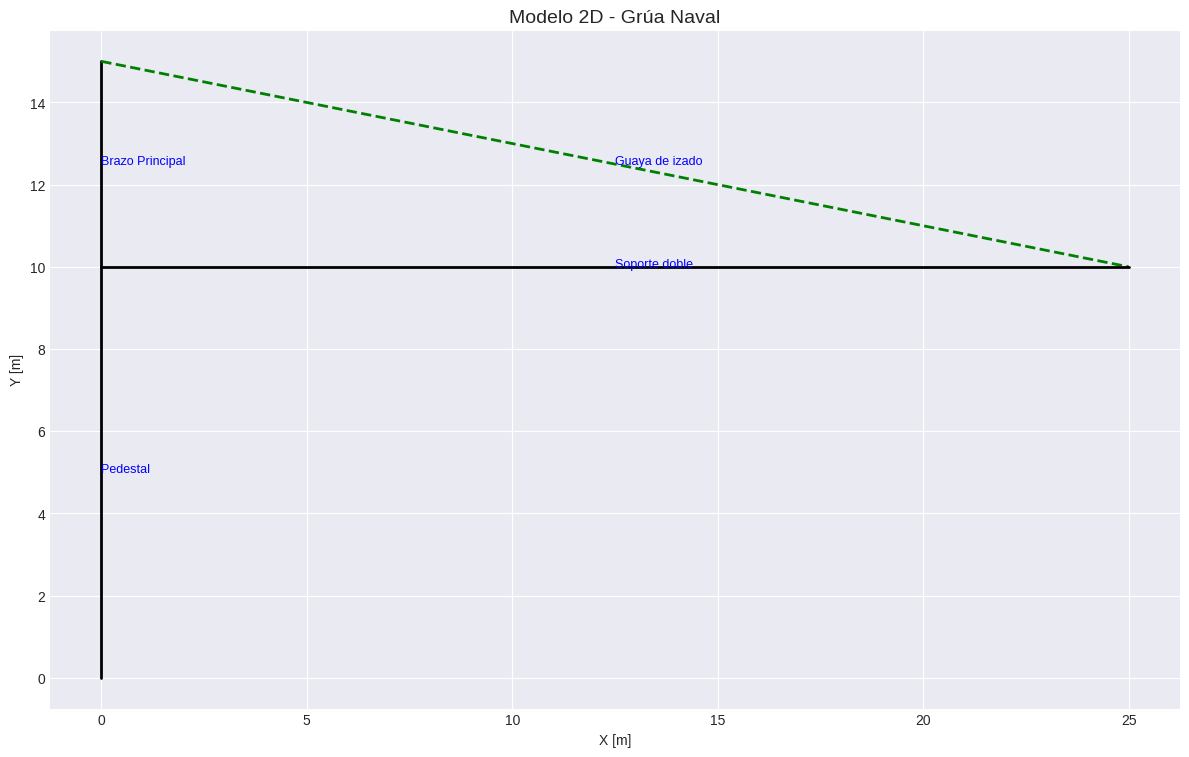

/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.

<ipython-input-7-71ed7ffd1e61>:436: UserWarning:

Glyph 128295 (\N{WRENCH}) missing from font(s) Liberation Sans.



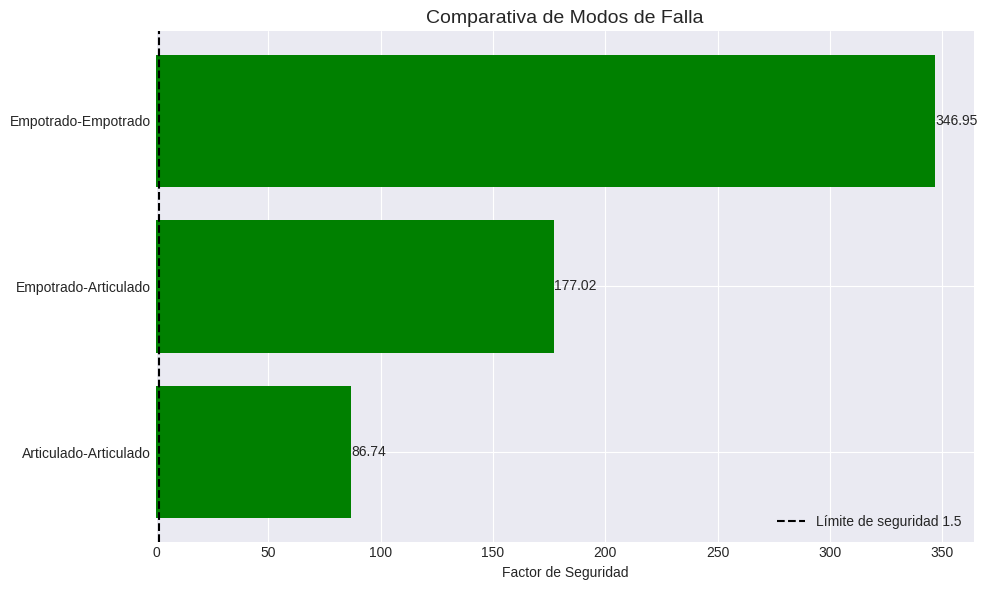

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128295 (\N{WRENCH}) missing from font(s) Liberation Sans.



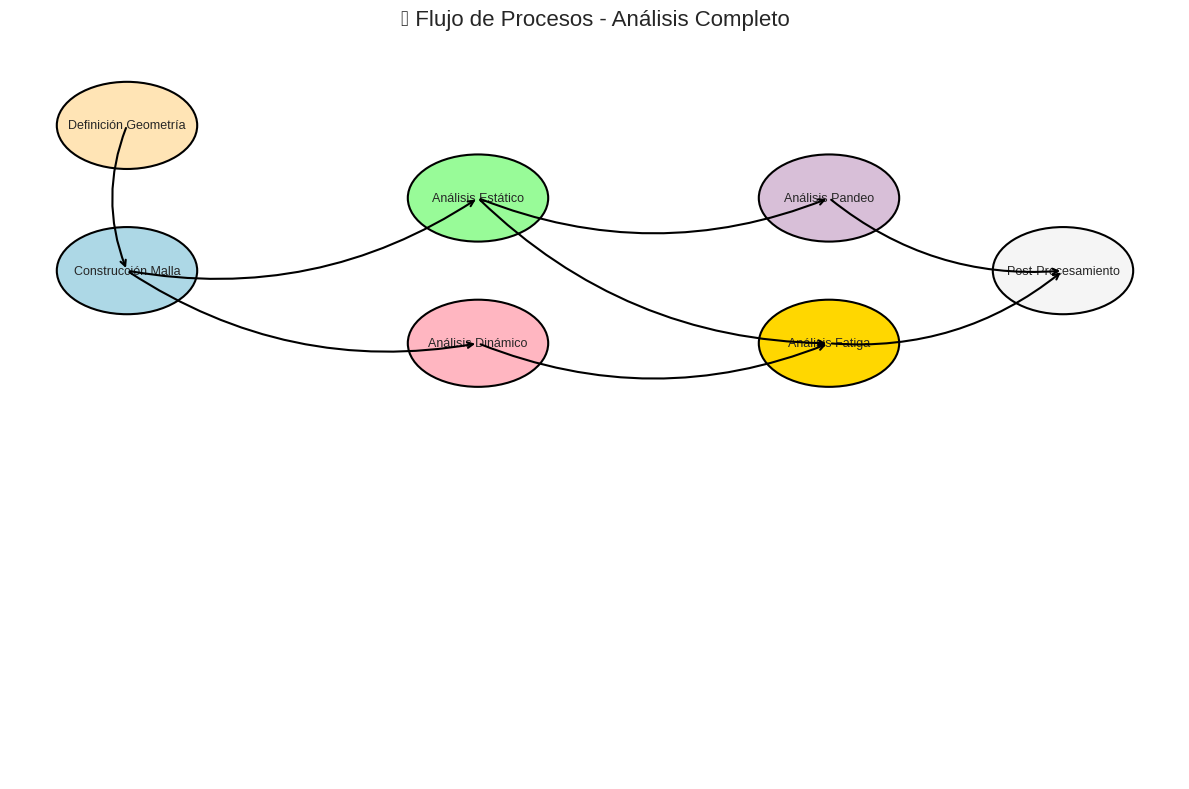

In [7]:
# =====================================================
# 🚀 ANÁLISIS DE GRÚA NAVAL - VERSIÓN 5.0 PROFESIONAL
# =====================================================
# Incluye:
# 1. Modelado geométrico 2D/3D
# 2. Análisis estructural FEM
# 3. Análisis de pandeo crítico
# 4. Análisis dinámico
# 5. Análisis de fatiga
# 6. Visualización avanzada
# 7. Exportación profesional
# =====================================================

# =====================================================
# 📚 SECCIÓN 1: DEFINICIÓN DE DATOS Y CONSTANTES
# =====================================================

import numpy as np
import matplotlib.pyplot as plt
import logging
import json
import math
from dataclasses import dataclass
from typing import Dict, Tuple, List
from enum import Enum
from pathlib import Path
import plotly.graph_objects as go
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import odeint
from IPython.display import display, HTML

# Configuración inicial
plt.style.use('seaborn-v0_8-darkgrid')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constantes
GRAVEDAD = 9.80665  # m/s²
PI = np.pi

# Definición de materiales y parámetros
class Material(Enum):
    ASTM_A572 = {"E": 200e9, "rho": 7850, "sigma_y": 345e6, "S_fatiga": 250e6}
    AISI_316 = {"E": 193e9, "rho": 8000, "sigma_y": 205e6, "S_fatiga": 150e6}

@dataclass
class ShipParams:
    eslora: float = 127.0
    manga: float = 22.0
    calado: float = 8.5
    pos_grua: Tuple[float, float] = (18.7, 5.3)
    tipo_buque: str = "Carga general"

@dataclass
class CraneParams:
    capacidad: float = 20.0
    longitud_brazo: float = 25.0
    peso: float = 120.0
    material: Material = Material.ASTM_A572
    angulo_max: float = 270.0
    velocidad_izar: float = 0.5

@dataclass
class EnviromentParams:
    ola_altura: float = 3.0
    ola_periodo: float = 8.0
    viento_velocidad: float = 15.0

# =====================================================
# 🛠️ SECCIÓN 2: UTILIDADES GENERALES
# =====================================================

class NavalUtils:
    @staticmethod
    def toneladas_a_newton(toneladas: float) -> float:
        """Convierte toneladas métricas a Newtons."""
        return toneladas * 1000 * GRAVEDAD

    @staticmethod
    def calcular_seguridad(esfuerzo_real: float, esfuerzo_permisible: float) -> float:
        """Calcula factor de seguridad."""
        if esfuerzo_real == 0:
            return float('inf')
        return esfuerzo_permisible / esfuerzo_real

    @staticmethod
    def exportar_json(data: Dict, filename: str = "resultados"):
        """Exporta datos a archivo JSON."""
        path = Path(f"{filename}.json")
        with open(path, "w") as f:
            json.dump(data, f, indent=4)
        logging.info(f"Datos exportados a {path}")
        return path

    @staticmethod
    def mostrar_tabla(data: Dict, titulo: str = ""):
        """Muestra datos como tabla HTML."""
        html = f"<h3>{titulo}</h3><table>"
        for k, v in data.items():
            html += f"<tr><td><b>{k}</b></td><td>{v}</td></tr>"
        html += "</table>"
        display(HTML(html))

# =====================================================
# 📐 SECCIÓN 3: MODELADO GEOMÉTRICO
# =====================================================

class ModeladorGrafico:
    """Genera visualizaciones 2D y 3D de la grúa naval."""

    def __init__(self, ship: ShipParams, crane: CraneParams):
        self.ship = ship
        self.crane = crane

    def modelo_2d_grua(self, show: bool = True) -> plt.Figure:
        """Crea un modelo 2D detallado de la grúa."""
        fig, ax = plt.subplots(figsize=(12,8))
        nodos = {
            1: [0, 0],
            2: [0, 10],
            3: [0, 15],
            4: [25, 10]
        }
        elementos = {
            "Pedestal": (1, 2),
            "Brazo Principal": (2, 3),
            "Guaya de izado": (3, 4),
            "Soporte doble": (2, 4)
        }
        for nombre, (ini, fin) in elementos.items():
            x = [nodos[ini][0], nodos[fin][0]]
            y = [nodos[ini][1], nodos[fin][1]]
            estilo = 'k-' if 'Brazo' in nombre or 'Pedestal' in nombre or 'Soporte' in nombre else 'g--'
            ax.plot(x, y, estilo, lw=2)
            xm, ym = (np.array(nodos[ini]) + np.array(nodos[fin])) / 2
            ax.text(xm, ym, nombre, fontsize=9, color='blue')

        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_title('Modelo 2D - Grúa Naval', fontsize=14)
        ax.set_aspect('equal')
        ax.grid(True)
        plt.tight_layout()
        if show:
            plt.show()
        return fig

    def modelo_3d_grua(self) -> go.Figure:
        """Genera modelo 3D interactivo de la grúa."""
        x = [0, 0, 0, 25]
        y = [0, 0, 0, 5]
        z = [0, 10, 15, 10]
        fig = go.Figure(data=[go.Scatter3d(
            x=x, y=y, z=z,
            mode='lines+markers',
            marker=dict(size=5, color='red'),
            line=dict(color='blue', width=5)
        )])
        fig.update_layout(
            title="Modelo 3D Grúa Naval",
            scene=dict(
                xaxis_title="Eslora (m)",
                yaxis_title="Manga (m)",
                zaxis_title="Altura (m)"
            )
        )
        return fig

# =====================================================
# ⚙️ SECCIÓN 4: ANÁLISIS ESTRUCTURAL FEM
# =====================================================

class AnalisisFEM:
    """Clase que implementa el Análisis Estructural mediante FEM."""

    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value
        self.K = None
        self.F = None
        self.u = None

    def construir_matriz_rigidez(self, n_nodos: int = 20):
        """Construye la matriz de rigidez del sistema."""
        dof = n_nodos * 3  # 3 grados de libertad por nodo (X, Y, θ)
        self.K = lil_matrix((dof, dof))
        E = self.material["E"]
        A = 0.1  # Área (m²)
        I = 0.01  # Inercia (m⁴)
        L = self.crane.longitud_brazo / (n_nodos - 1)

        # Matriz de rigidez local de un elemento tipo beam 2D
        k_local = np.array([
            [E*A/L, 0, 0, -E*A/L, 0, 0],
            [0, 12*E*I/L**3, 6*E*I/L**2, 0, -12*E*I/L**3, 6*E*I/L**2],
            [0, 6*E*I/L**2, 4*E*I/L, 0, -6*E*I/L**2, 2*E*I/L],
            [-E*A/L, 0, 0, E*A/L, 0, 0],
            [0, -12*E*I/L**3, -6*E*I/L**2, 0, 12*E*I/L**3, -6*E*I/L**2],
            [0, 6*E*I/L**2, 2*E*I/L, 0, -6*E*I/L**2, 4*E*I/L]
        ])

        for i in range(n_nodos-1):
            start = i * 3
            end = (i+1) * 3
            self.K[start:end+3, start:end+3] += k_local

        logging.info(f"Matriz de rigidez construida para {n_nodos} nodos.")

    def aplicar_cargas(self, carga_nodal: Dict[int, float]):
        """Aplica cargas nodales sobre el sistema."""
        dof = self.K.shape[0]
        self.F = np.zeros(dof)

        for nodo, carga in carga_nodal.items():
            pos = nodo * 3 + 1  # Carga en dirección Y
            if pos < dof:
                self.F[pos] = -carga  # Negativa por dirección descendente

        logging.info(f"Cargas aplicadas en {len(carga_nodal)} nodos.")

    def resolver(self, restricciones: List[int]) -> np.ndarray:
        """Resuelve el sistema FEM aplicando restricciones."""
        if self.K is None or self.F is None:
            raise ValueError("Sistema incompleto.")

        K_mod = self.K.tocsc()
        F_mod = self.F.copy()

        for dof in restricciones:
            if dof < K_mod.shape[0]:
                K_mod[dof, :] = 0
                K_mod[:, dof] = 0
                K_mod[dof, dof] = 1
                F_mod[dof] = 0

        self.u = spsolve(K_mod, F_mod)
        logging.info("Sistema FEM resuelto.")
        return self.u

    def post_procesar(self) -> Dict:
        """Calcula esfuerzos y factores de seguridad."""
        if self.u is None:
            raise ValueError("Sistema no resuelto.")

        deformacion_max = np.max(np.abs(self.u))
        esfuerzo_max = self.material["E"] * deformacion_max / self.crane.longitud_brazo
        fs_yield = NavalUtils.calcular_seguridad(esfuerzo_max, self.material["sigma_y"])

        return {
            "deformacion_max": deformacion_max,
            "esfuerzo_max": esfuerzo_max,
            "fs_yield": fs_yield,
            "estado": "✅ Seguro" if fs_yield > 1.5 else "⚠️ Riesgo"
        }

# =====================================================
# 🧩 SECCIÓN 5: ANÁLISIS DE PANDEO
# =====================================================

class AnalisisPandeo:
    """Clase que analiza la carga crítica de pandeo de elementos."""

    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value

    def calcular_carga_critica(self, tipo_apoyo: str = "articulado") -> float:
        """Calcula la carga crítica de pandeo según condición de apoyo."""
        L = self.crane.longitud_brazo
        E = self.material["E"]
        I = self._inercia_aproximada()
        factores_K = {
            "articulado-articulado": 1.0,
            "empotrado-articulado": 0.7,
            "empotrado-empotrado": 0.5,
            "empotrado-libre": 2.0
        }
        K = factores_K.get(tipo_apoyo, 1.0)
        P_cr = (PI**2 * E * I) / ((K * L)**2)
        return P_cr

    def _inercia_aproximada(self) -> float:
        """Calcula un momento de inercia aproximado."""
        D_ext = 0.8  # Diámetro exterior [m]
        t = 0.03     # Espesor [m]
        return (PI/64) * (D_ext**4 - (D_ext - 2*t)**4)

    def evaluar_pandeo(self, carga_aplicada: float) -> Dict:
        """Evalúa el riesgo de pandeo comparando con cargas críticas."""
        cargas = {
            "Articulado-Articulado": self.calcular_carga_critica("articulado-articulado"),
            "Empotrado-Articulado": self.calcular_carga_critica("empotrado-articulado"),
            "Empotrado-Empotrado": self.calcular_carga_critica("empotrado-empotrado")
        }
        resultados = {}
        for tipo, Pcr in cargas.items():
            fs = Pcr / carga_aplicada
            resultados[tipo] = {
                "carga_critica": Pcr,
                "factor_seguridad": fs,
                "estado": "✅ Estable" if fs > 1.5 else "⚠️ Revisar"
            }
        return resultados

# =====================================================
# 🌊 SECCIÓN 6: ANÁLISIS DINÁMICO (RESPUESTA OLEAJE)
# =====================================================

class AnalisisDinamico:
    """Clase que simula respuesta dinámica de la grúa a oleaje."""

    def __init__(self, crane: CraneParams, env: EnviromentParams):
        self.crane = crane
        self.env = env
        self.material = crane.material.value

    def simular_respuesta(self, t_max: float = 60.0) -> Dict:
        """Simula la respuesta dinámica frente a oleaje."""
        masa = self.crane.peso * 1000
        k = self.material["E"] * 0.01
        c = 0.1 * np.sqrt(k * masa)

        def excitacion(t):
            return (self.env.ola_altura / 2) * np.sin(2 * PI * t / self.env.ola_periodo)

        def ecuacion(u, t):
            x, v = u
            dxdt = v
            dvdt = (excitacion(t) - c*v - k*x) / masa
            return [dxdt, dvdt]

        t = np.linspace(0, t_max, 1000)
        u0 = [0.0, 0.0]
        sol = odeint(ecuacion, u0, t)

        return {
            "tiempo": t,
            "desplazamiento": sol[:, 0],
            "velocidad": sol[:, 1],
            "aceleracion": np.gradient(sol[:, 1], t)
        }
# =====================================================
# 🔄 SECCIÓN 7: ANÁLISIS DE FATIGA
# =====================================================

class AnalisisFatiga:
    """Clase que estima la vida a fatiga de la estructura."""

    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value

    def estimar_vida(self, rango_esfuerzo: float, ciclos_por_año: int = 1e6) -> Dict:
        """
        Estima la vida útil de la grúa bajo cargas cíclicas usando criterio de Basquin.

        Args:
            rango_esfuerzo (float): Rango de esfuerzo cíclico aplicado [Pa].
            ciclos_por_año (int): Número de ciclos por año.

        Returns:
            Dict: Resultados de vida estimada.
        """
        S_f = self.material["S_fatiga"]

        vida_ciclos = (S_f / (rango_esfuerzo/2)) ** 6
        vida_anios = vida_ciclos / ciclos_por_año

        return {
            "rango_esfuerzo": rango_esfuerzo,
            "vida_ciclos": vida_ciclos,
            "vida_anios": vida_anios,
            "estado": "✅ Adecuada" if vida_anios > 20 else "⚠️ Revisar diseño"
        }

# =====================================================
# 🎨 SECCIÓN 8: VISUALIZACIÓN AVANZADA
# =====================================================

class Visualizador:
    """Clase para crear visualizaciones profesionales."""

    @staticmethod
    def plot_modos_falla(resultados: Dict) -> plt.Figure:
        """Genera gráfico comparativo de factores de seguridad de modos de falla."""
        fig, ax = plt.subplots(figsize=(10, 6))

        modos = list(resultados.keys())
        factores = [v["factor_seguridad"] for v in resultados.values()]

        bars = ax.barh(modos, factores, color=["green" if fs > 1.5 else "red" for fs in factores])

        ax.axvline(1.5, color="k", linestyle="--", label="Límite de seguridad 1.5")
        ax.set_xlabel("Factor de Seguridad")
        ax.set_title("Comparativa de Modos de Falla", fontsize=14)
        ax.legend()

        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, f"{width:.2f}", ha='left', va='center')

        plt.tight_layout()
        return fig

    @staticmethod
    def diagrama_flujo_proceso() -> plt.Figure:
        """Dibuja diagrama de flujo del proceso de análisis."""
        fig, ax = plt.subplots(figsize=(12,8))
        ax.axis('off')

        nodos = [
            {"texto": "Definición Geometría", "pos": (0.1, 0.9), "color": "#FFE4B5"},
            {"texto": "Construcción Malla", "pos": (0.1, 0.7), "color": "#ADD8E6"},
            {"texto": "Análisis Estático", "pos": (0.4, 0.8), "color": "#98FB98"},
            {"texto": "Análisis Dinámico", "pos": (0.4, 0.6), "color": "#FFB6C1"},
            {"texto": "Análisis Pandeo", "pos": (0.7, 0.8), "color": "#D8BFD8"},
            {"texto": "Análisis Fatiga", "pos": (0.7, 0.6), "color": "#FFD700"},
            {"texto": "Post-Procesamiento", "pos": (0.9, 0.7), "color": "#F5F5F5"}
        ]

        for nodo in nodos:
            ax.add_patch(plt.Circle(nodo["pos"], 0.06, color=nodo["color"], ec="black", lw=1.5))
            ax.text(nodo["pos"][0], nodo["pos"][1], nodo["texto"], ha='center', va='center', fontsize=9)

        conexiones = [
            (0, 1), (1, 2), (1, 3),
            (2, 4), (2, 5), (3, 5),
            (4, 6), (5, 6)
        ]

        for i, j in conexiones:
            ax.annotate("", xy=nodos[j]["pos"], xytext=nodos[i]["pos"],
                        arrowprops=dict(arrowstyle="->", lw=1.5, connectionstyle="arc3,rad=0.2"))

        ax.set_title("🔧 Flujo de Procesos - Análisis Completo", fontsize=16, pad=20)
        plt.tight_layout()
        return fig
# =====================================================
# 📤 SECCIÓN 9: EXPORTACIÓN DE RESULTADOS
# =====================================================

class ReportGenerator:
    """Clase para generar reportes profesionales en HTML o Markdown."""

    @staticmethod
    def generar_reporte_html(resultados: Dict) -> str:
        """Genera un reporte en formato HTML a partir de resultados."""
        html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <style>
                body {{ font-family: Arial, sans-serif; }}
                h1 {{ color: #2E86C1; }}
                table {{ width: 100%; border-collapse: collapse; }}
                th, td {{ padding: 10px; text-align: left; border-bottom: 1px solid #ddd; }}
                tr:hover {{ background-color: #f1f1f1; }}
            </style>
        </head>
        <body>
            <h1>Reporte de Análisis - Grúa Naval</h1>
            <h2>Resultados Principales</h2>
            <table>
                <tr><th>Parámetro</th><th>Valor</th></tr>
                <tr><td>Esfuerzo Máximo [Pa]</td><td>{resultados['fem']['esfuerzo_max']:.2f}</td></tr>
                <tr><td>Factor de Seguridad</td><td>{resultados['fem']['fs_yield']:.2f}</td></tr>
                <tr><td>Estado General</td><td>{resultados['fem']['estado']}</td></tr>
            </table>
            <h2>Análisis de Pandeo</h2>
            <table>
                <tr><th>Condición</th><th>Carga Crítica [N]</th><th>Factor Seguridad</th><th>Estado</th></tr>
        """
        for condicion, datos in resultados['pandeo'].items():
            html += f"""
                <tr>
                    <td>{condicion}</td>
                    <td>{datos['carga_critica']:.2f}</td>
                    <td>{datos['factor_seguridad']:.2f}</td>
                    <td>{datos['estado']}</td>
                </tr>
            """
        html += """
            </table>
        </body>
        </html>
        """
        return html

    @staticmethod
    def exportar_resultados(resultados: Dict, nombre_base: str = "reporte_grua"):
        """Exporta resultados a JSON y HTML."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        json_path = Path(f"{nombre_base}_{timestamp}.json")
        html_path = Path(f"{nombre_base}_{timestamp}.html")

        # Exportar JSON
        with open(json_path, "w") as f_json:
            json.dump(resultados, f_json, indent=4)

        # Exportar HTML
        reporte_html = ReportGenerator.generar_reporte_html(resultados)
        with open(html_path, "w") as f_html:
            f_html.write(reporte_html)

        logging.info(f"Resultados exportados: {json_path} y {html_path}")
        return json_path, html_path

# =====================================================
# 🧠 SECCIÓN 10: EJECUCIÓN PRINCIPAL
# =====================================================

def main():
    """Función principal que coordina el análisis completo."""
    logging.info("🚀 Iniciando Análisis de la Grúa Naval...")

    # Parámetros iniciales
    buque = ShipParams()
    grua = CraneParams()
    ambiente = EnviromentParams()

    NavalUtils.mostrar_tabla({
        "Buque": f"{buque.eslora}m x {buque.manga}m",
        "Grúa": f"{grua.capacidad} Ton @ {grua.longitud_brazo}m",
        "Material": grua.material.name
    }, "Parámetros Iniciales")

    # Modelado
    modelador = ModeladorGrafico(buque, grua)
    modelador.modelo_2d_grua(show=True)
    modelador.modelo_3d_grua().show()

    # Análisis FEM
    fem = AnalisisFEM(grua)
    fem.construir_matriz_rigidez()
    carga_nodal = {15: NavalUtils.toneladas_a_newton(grua.capacidad)}
    fem.aplicar_cargas(carga_nodal)
    desplazamientos = fem.resolver(restricciones=[0, 1, 2])
    resultados_fem = fem.post_procesar()

    # Análisis de Pandeo
    pandeo = AnalisisPandeo(grua)
    resultados_pandeo = pandeo.evaluar_pandeo(NavalUtils.toneladas_a_newton(grua.capacidad))

    # Análisis Dinámico
    dinamico = AnalisisDinamico(grua, ambiente)
    resultados_dinamico = dinamico.simular_respuesta()

    # Análisis de Fatiga
    fatiga = AnalisisFatiga(grua)
    resultados_fatiga = fatiga.estimar_vida(rango_esfuerzo=resultados_fem["esfuerzo_max"] * 0.3)

    # Visualización Avanzada
    visualizador = Visualizador()
    fig_modos = visualizador.plot_modos_falla(resultados_pandeo)
    fig_flujo = visualizador.diagrama_flujo_proceso()

    plt.show()

    # Consolidar Resultados
    resultados_finales = {
        "ship": vars(buque),
        "crane": {**vars(grua), "material": grua.material.value},
        "fem": resultados_fem,
        "pandeo": resultados_pandeo,
        "dinamico": {
            "desplazamiento_max": np.max(resultados_dinamico["desplazamiento"]),
            "aceleracion_max": np.max(resultados_dinamico["aceleracion"])
        },
        "fatiga": resultados_fatiga
    }

    # Exportación de reportes
    ReportGenerator.exportar_resultados(resultados_finales)

    logging.info("✅ Análisis completo terminado.")

# Ejecutar main
if __name__ == "__main__":
    main()
